In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, GRU, Dense, Reshape
from tensorflow.keras.layers import Layer, GlobalMaxPooling1D, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
import time

In [ ]:
# Load dataset
data = pd.read_csv("/content/dataset_full.csv")
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (88647, 112)
   qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
0            3               0                  0              1   
1            5               0                  1              3   
2            2               0                  0              1   
3            4               0                  2              5   
4            2               0                  0              0   

   qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
0                     0              0           0            0   
1                     0              3           0            2   
2                     0              0           0            0   
3                     0              0           0            0   
4                     0              0           0            0   

   qty_exclamation_url  qty_space_url  ...  qty_ip_resolved  qty_nameservers  \
0                    0              0  ...                1                2   


In [ ]:
# Preprocessing
data = data.dropna().drop_duplicates()
boolean_columns = ['email_in_url', 'domain_in_ip', 'server_client_domain', 'tld_present_params', 'domain_spf', 'tls_ssl_certificate', 'url_google_index', 'domain_google_index', 'url_shortened', 'phishing']
data[boolean_columns] = data[boolean_columns].astype(int)
numerical_columns = [col for col in data.columns if col not in boolean_columns]
scaler_standard = StandardScaler()
data[numerical_columns] = scaler_standard.fit_transform(data[numerical_columns])
scaler_minmax = MinMaxScaler()
data[numerical_columns] = scaler_minmax.fit_transform(data[numerical_columns])
joblib.dump(scaler_standard, "scaler_standard.pkl")
joblib.dump(scaler_minmax, "scaler_minmax.pkl")
data.to_csv("newphishdata.csv", index=False)

In [ ]:
# Train-test split
X = data.drop(columns=['phishing'])
y = data['phishing']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [ ]:
# Custom Neural Field Attention Layer
class NeuralFieldAttention(Layer):
    def __init__(self, timesteps=10, lambda_strength=0.1, **kwargs):
        super().__init__(**kwargs)
        self.timesteps = timesteps
        self.lambda_strength = lambda_strength

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        I = inputs
        u = tf.zeros_like(I)
        for _ in range(self.timesteps):
            interaction = tf.matmul(I, self.kernel)
            activation = tf.nn.relu(u)
            delta = tf.reduce_mean(tf.abs(I - tf.reduce_mean(I, axis=1, keepdims=True)), axis=-1, keepdims=True)
            delta = tf.tile(delta, [1, 1, inputs.shape[-1]])
            u = u + (-u + interaction + I + self.lambda_strength * delta)
        attention_scores = tf.nn.softmax(u, axis=1)
        return tf.reduce_sum(attention_scores * inputs, axis=1)

In [ ]:
# === Build CNN + GRU + Attention Model ===
input_shape = X_train.shape[1:]
inputs = Input(shape=input_shape)

# CNN block
x = Conv1D(32, kernel_size=3, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, kernel_size=3, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dropout(0.2)(x)

# GRU Layer
x = GRU(64, return_sequences=True)(x)

# Neural Field Attention
x = NeuralFieldAttention(timesteps=5, lambda_strength=0.2)(x)

# Fully connected layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [ ]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 111, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 109, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 52, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 26, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 26, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 26, 64)              │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ neural_field_attention               │ (None, 64)                  │           4,096 │
│ (NeuralFieldAttention)               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,665 (162.75 KB)

 Trainable params: 41,665 (162.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epoch_times = []

def on_epoch_begin(epoch, logs=None):
    global epoch_start_time
    epoch_start_time = time.time()

def on_epoch_end(epoch, logs=None):
    epoch_times.append(time.time() - epoch_start_time)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f}s")

time_callback = LambdaCallback(on_epoch_begin=on_epoch_begin, on_epoch_end=on_epoch_end)

In [ ]:
# Train
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=64,  # Optimized batch size
                    callbacks=[early_stopping, time_callback],
                    verbose=1)

Epoch 1/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8487 - auc: 0.8962 - loss: 0.3517 - precision: 0.7280 - recall: 0.9020Epoch 1 time: 48.38s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 48s 40ms/step - accuracy: 0.8487 - auc: 0.8963 - loss: 0.3517 - precision: 0.7280 - recall: 0.9021 - val_accuracy: 0.8657 - val_auc: 0.9422 - val_loss: 0.2955 - val_precision: 0.7311 - val_recall: 0.9744
Epoch 2/50
1090/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8712 - auc: 0.9371 - loss: 0.2838 - precision: 0.7633 - recall: 0.9209Epoch 2 time: 80.91s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - accuracy: 0.8713 - auc: 0.9371 - loss: 0.2837 - precision: 0.7633 - recall: 0.9208 - val_accuracy: 0.9034 - val_auc: 0.9687 - val_loss: 0.2196 - val_precision: 0.8611 - val_recall: 0.8629
Epoch 3/50
1089/1091 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8975 - auc: 0.9614 - loss: 0.2352 - precision: 0.8239 - recall: 0.8991Epoch 3 time: 77.02s
1091/1091 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - acc

In [ ]:
# Predict & Evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display
print("\nMetrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

546/546 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step

Metrics:
Accuracy: 0.9533
Precision: 0.9368
Recall: 0.9290
AUC: 0.9477
Confusion Matrix:
[[10961   382]
 [  433  5666]]


In [ ]:
# FAR & FRR
fp, fn = conf_matrix[0][1], conf_matrix[1][0]
tn, tp = conf_matrix[0][0], conf_matrix[1][1]
far = fp / (fp + tn)
frr = fn / (fn + tp)
print("\nFAR:", round(far, 4))
print("FRR:", round(frr, 4))
print("Avg Epoch Time:", round(np.mean(epoch_times), 2), "seconds")


FAR: 0.0337
FRR: 0.071
Avg Epoch Time: 48.19 seconds


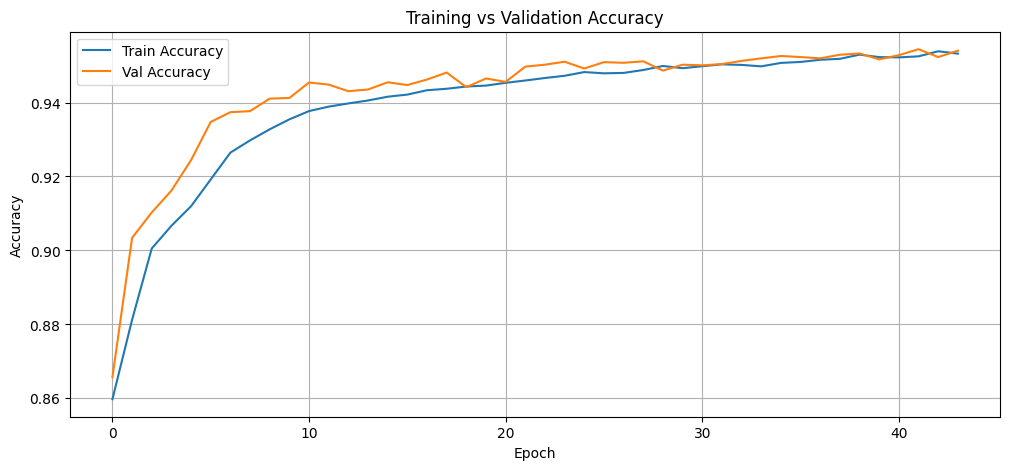

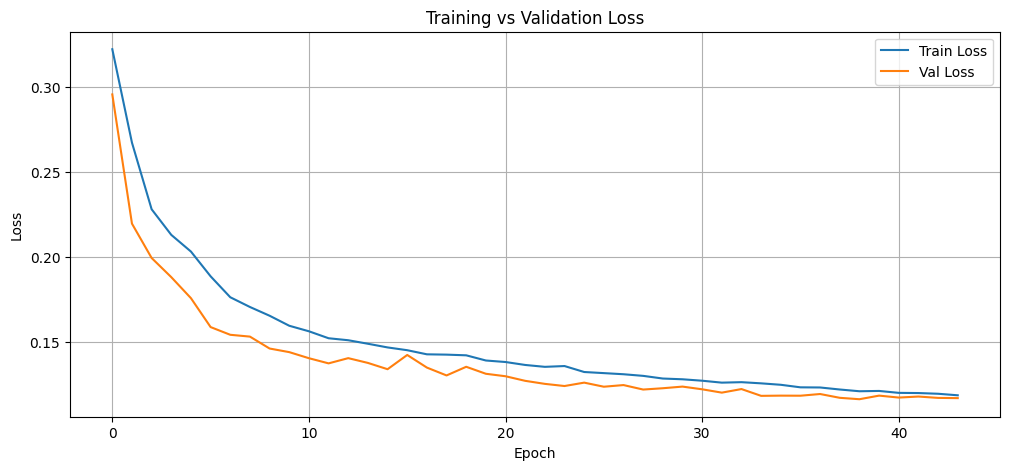

In [ ]:
# Save training history
np.save("model_history_cnn_gru_nfa.npy", history.history)

# Accuracy Plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()